In [51]:
from PyHessian.pyhessian.hessian import hessian
from PyHessian.density_plot import get_esd_plot
import torch
import torch.nn as nn
import numpy as np
from torchvision import datasets, transforms
# from keras.datasets import mnist
import matplotlib.pyplot as plt 
import time

In [52]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [53]:
mnist_trainset = datasets.MNIST(root='./data/mnist', train=True, download=True, transform=transforms.ToTensor())
mnist_fashion_trainset = datasets.FashionMNIST(root='./data/fashion_mnist', train=True, download=True, transform=transforms.ToTensor())
cifar_trainset = datasets.CIFAR10(root='./data/cifar10', train=True, download=True, transform=transforms.ToTensor())
# Getting mnist test data
mnist_testset = datasets.MNIST(root='./data/mnist', train=False, download=True, transform=transforms.ToTensor())
mnist_fashion_testset = datasets.FashionMNIST(root='./data/fashion_mnist', train=False, download=True, transform=transforms.ToTensor())
cifar_testset = datasets.CIFAR10(root='./data/cifar10', train=False, download=True, transform=transforms.ToTensor())

torch.manual_seed(42)

Files already downloaded and verified
Files already downloaded and verified


In [54]:
train_X = mnist_fashion_trainset.data
train_y = mnist_fashion_trainset.targets
test_X = mnist_fashion_testset.data
test_y = mnist_fashion_testset.targets

In [55]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [56]:
train_X = (torch.tensor(train_X, dtype=torch.float32)/255).to(device)
test_X = (torch.tensor(test_X, dtype=torch.float32)/255).to(device)
train_y = (torch.tensor(train_y, dtype=torch.int64)).to(device)
test_y = (torch.tensor(test_y, dtype=torch.int64)).to(device)

/tmp/ipykernel_5597/2213468680.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_X = (torch.tensor(train_X, dtype=torch.float32)/255).to(device)
/tmp/ipykernel_5597/2213468680.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_X = (torch.tensor(test_X, dtype=torch.float32)/255).to(device)
/tmp/ipykernel_5597/2213468680.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_y = (torch.tensor(train_y, dtype=torch.int64)).to(device)
/tmp/ipykernel_5597/2213468680.py:4: UserWarning: To copy construct from a tensor, it is reco

In [57]:
dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(train_X, train_y),
    batch_size=64, shuffle=True)
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [58]:
losses = []
test_losses = []
train_losses = []
for epoch in range(10):
    for i, (data, target) in enumerate(dataloader):
        optimizer.zero_grad()
        output = model(data)
        #output_test = model(test_X)
        loss = criterion(output, target)
        # loss_test = criterion(output_test, test_y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if i % 500 == 0:
            output = model(train_X)
            loss_train = criterion(output, train_y)
            output = model(test_X)
            loss_test = criterion(output, test_y)
            print(f"Epoch {epoch}, step {i}, train_loss {loss.item()}, test_loss {loss_test.item()}")
            output_test = model(test_X)
            test_losses.append(loss_test.item())
            train_losses.append(loss_train.item())
    #print(loss.item())

Epoch 0, step 0, train_loss 2.309023141860962, test_loss 2.267585515975952


Epoch 0, step 500, train_loss 0.7108812928199768, test_loss 0.48654547333717346
Epoch 1, step 0, train_loss 0.33341315388679504, test_loss 0.44879150390625
Epoch 1, step 500, train_loss 0.4083273410797119, test_loss 0.4121437966823578
Epoch 2, step 0, train_loss 0.30441248416900635, test_loss 0.4071321189403534
Epoch 2, step 500, train_loss 0.18398724496364594, test_loss 0.4018801748752594
Epoch 3, step 0, train_loss 0.31918227672576904, test_loss 0.3869290053844452
Epoch 3, step 500, train_loss 0.2477884590625763, test_loss 0.3975917398929596
Epoch 4, step 0, train_loss 0.2756894826889038, test_loss 0.39126041531562805
Epoch 4, step 500, train_loss 0.18082724511623383, test_loss 0.34873002767562866
Epoch 5, step 0, train_loss 0.20777860283851624, test_loss 0.3486612141132355
Epoch 5, step 500, train_loss 0.3609946072101593, test_loss 0.37359529733657837
Epoch 6, step 0, train_loss 0.2505502700805664, test_loss 0.3632728159427643
Epoch 6, step 500, train_loss 0.22102095186710358, test_

In [59]:
# Calculate test accuracy
output = model(test_X)
_, predicted = torch.max(output, 1)
correct = (predicted == test_y).sum().item()
accuracy = correct / test_y.size(0)
print(f"Test accuracy: {accuracy}")

Test accuracy: 0.8742


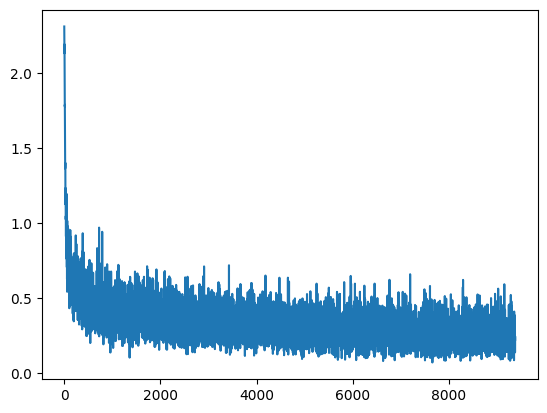

In [60]:
%matplotlib inline
plt.plot(losses)
plt.show()

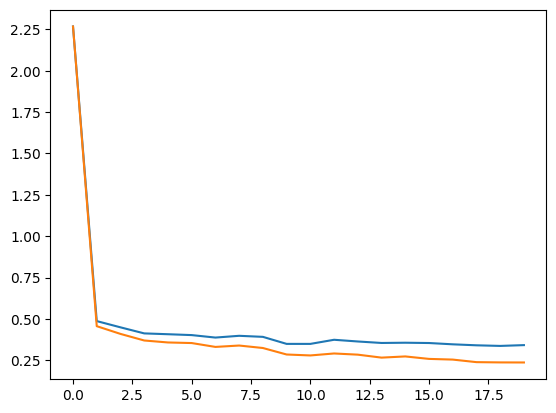

In [61]:
plt.plot(test_losses)
plt.plot(train_losses)
plt.show()

In [62]:
# finding test loss
output = model(train_X)
loss = criterion(output, train_y)
print(loss.item())

0.2562549412250519


In [63]:
hessian_comp = hessian(model, criterion, data=(train_X, train_y), cuda=False)

In [64]:
trace = hessian_comp.trace()
print("The trace of this model is: %.4f"%(np.mean(trace)))

The trace of this model is: 63.6918


In [65]:
# top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=20)
# print("The top two eigenvalues of this model are: ", top_eigenvalues)

Obtained eigendensities and eigenweights in 20.68 seconds


/teamspace/studios/this_studio/DeepHessian/PyHessian/density_plot.py:62: ComplexWarning: Casting complex values to real discards the imaginary part
  density_output[i, j] = np.sum(tmp_result * weights[i, :])


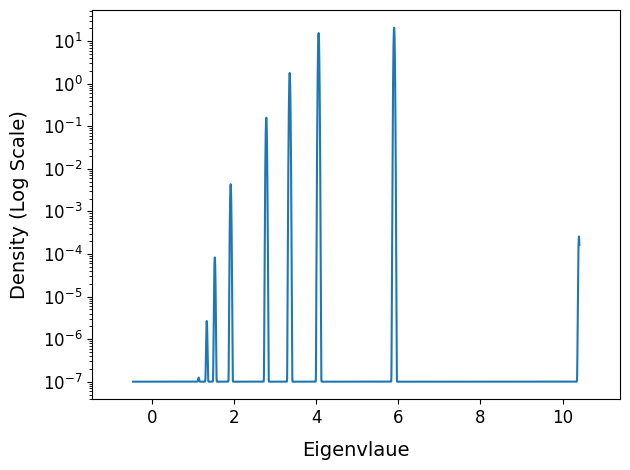

In [66]:
t0 = time.time()
density_eigen, density_weight = hessian_comp.density()
print("Obtained eigendensities and eigenweights in %.2f seconds"%(time.time()-t0))
get_esd_plot(density_eigen, density_weight)